**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

'''
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
'''        

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50

series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [16]:
y_train

array([[-0.35489398],
       [ 0.11629631],
       [-0.35395944],
       ...,
       [ 0.04946356],
       [-0.26231018],
       [ 0.60062087]], dtype=float32)

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

Saving figure time_series_plot


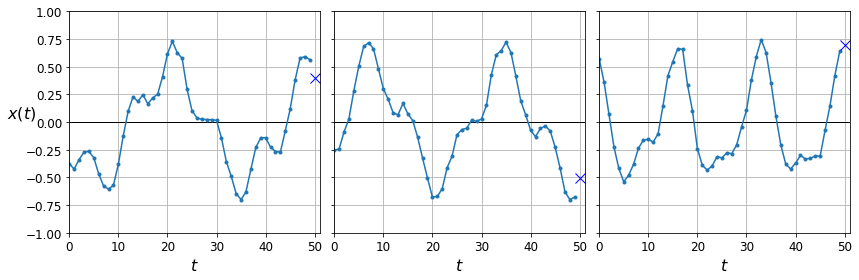

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

#### Naive predictions (just predict the last observed value):

In [ ]:
y_pred = X_valid[:, -1]
#np.mean() 
keras.losses.mean_squared_error(y_valid, y_pred)[:10]

<tf.Tensor: id=8, shape=(10,), dtype=float32, numpy=
array([0.02696938, 0.0300572 , 0.00259067, 0.07534433, 0.00045797,
       0.03665831, 0.00295946, 0.02947074, 0.04057578, 0.03133494],
      dtype=float32)>

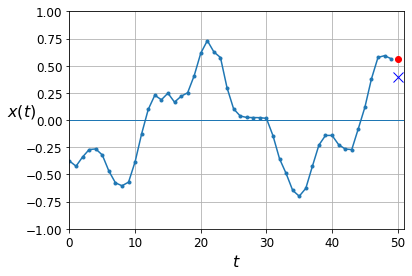

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
X_valid.shape

(2000, 50, 1)

#### Linear regression predictions:

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [8]:
# Linear model is better
model.evaluate(X_valid, y_valid, verbose=2)

63/63 - 0s - loss: 0.0042 - 81ms/epoch - 1ms/step


0.004168087616562843

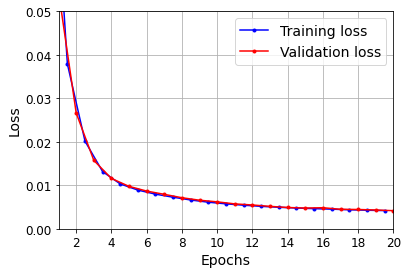

In [9]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

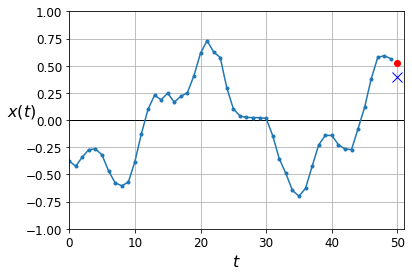

In [10]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/20
7000/7000 [==============================] - 7s 979us/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0146 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 7s 955us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0119 - val_loss: 0.0112
Epoch 10/20


In [ ]:
# Simple RNN brings a limited improvement over the base models (linear)
model.evaluate(X_valid, y_valid, verbose=2)

2000/1 - 0s - loss: 0.0099


0.01090382856875658

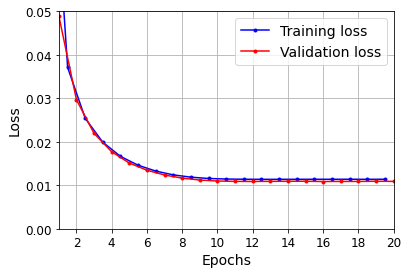

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

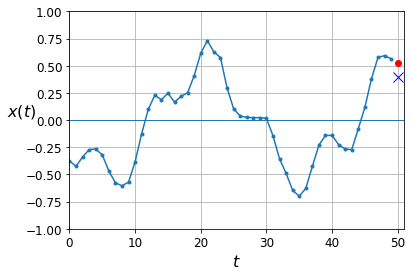

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 26s 4ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0044 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 1

In [ ]:
# Improved significanty
model.evaluate(X_valid, y_valid, verbose=2)

2000/1 - 1s - loss: 0.0033


0.0031113271843642

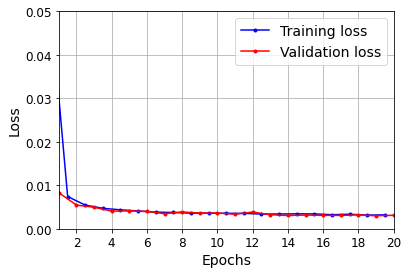

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

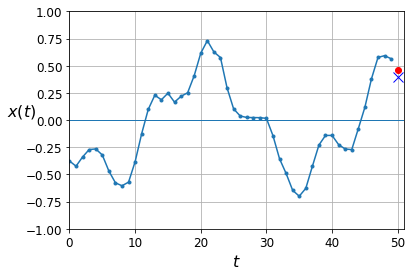

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Make the second `SimpleRNN` layer return only the last output (and replace the last layer with "Dense" one):

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0240 - val_loss: 0.0050
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0043 - val_loss: 0.0035
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 1

In [ ]:
model.evaluate(X_valid, y_valid, verbose=2)

2000/1 - 1s - loss: 0.0030


0.0028335081916302444

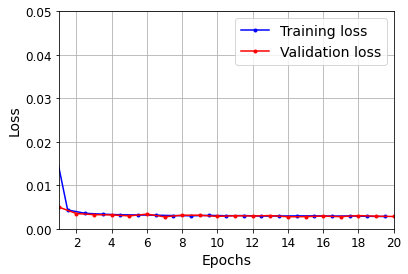

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

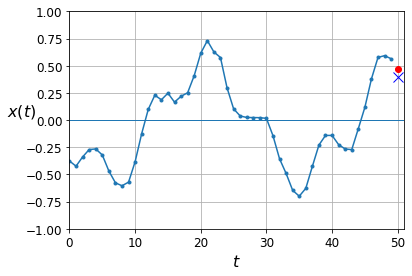

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


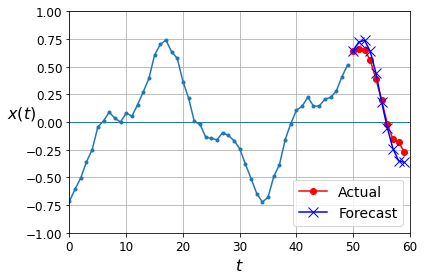

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one (using the predcitions from previous steps):

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [ ]:
Y_pred.shape

(2000, 10)

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.025828121

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [ ]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_FD = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model_FD.compile(loss="mse", optimizer="adam")
history_FD = model_FD.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 124us/sample - loss: 0.1335 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0385 - val_loss: 0.0354
Epoch 4/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0298 - val_loss: 0.0282
Epoch 6/20
7000/7000 [==============================] - 0s 64us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0257 - val_loss: 0.0249
Epoch 8/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0244 - val_loss: 0.0240
Epoch 9/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 

#### Now let's create an RNN that predicts all 10 next values at once:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_STS = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model_STS.compile(loss="mse", optimizer="adam")
history_STS = model_STS.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0110 - val_loss: 0.0116
Epoch 1

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_STS.predict(X_new)[..., np.newaxis]

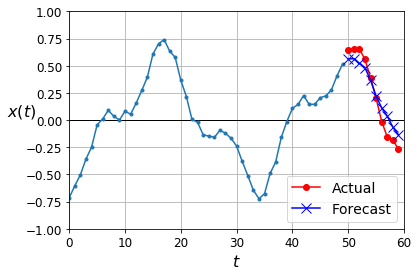

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Now let's create an RNN that predicts the next 10 steps at each time step. 

That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_all = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model_all.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_all = model_all.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0502 - last_time_step_mse: 0.0392 - val_loss: 0.0422 - val_last_time_step_mse: 0.0309
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0403 - last_time_step_mse: 0.0293 - val_loss: 0.0361 - val_last_time_step_mse: 0.0275
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0409 - last_time_step_mse: 0.0343 - val_loss: 0.0393 - val_last_time_step_mse: 0.0324
Epoch 4/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0333 - last_time_step_mse: 0.0236 - val_loss: 0.0327 - val_last_time_step_mse: 0.0252
Epoch 5/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0290 - last_time_step_mse: 0.0182 - val_loss: 0.0264 - val_last_time_step_mse: 0.0150
Epoch 6/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0251 - last_time_step_mse: 0.0134 - 

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model_all.predict(X_new)[:, -1][..., np.newaxis]

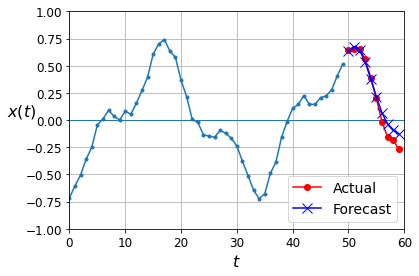

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Deep RNN with Batch Norm

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 765us/sample - loss: 0.1936 - last_time_step_mse: 0.1913 - val_loss: 0.0901 - val_last_time_step_mse: 0.0863
Epoch 2/20
7000/7000 [==============================] - 4s 607us/sample - loss: 0.0531 - last_time_step_mse: 0.0441 - val_loss: 0.0559 - val_last_time_step_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 4s 599us/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/20
7000/7000 [==============================] - 4s 550us/sample - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0423 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 4s 541us/sample - loss: 0.0414 - last_time_step_mse: 0.0310 - val_loss: 0.0402 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 4s 541us/sample - loss: 0.0390 - last_time_step_mse: 0.0

## Deep RNNs with Layer Norm

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.1539 - last_time_step_mse: 0.1506 - val_loss: 0.0701 - val_last_time_step_mse: 0.0641
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0627 - last_time_step_mse: 0.0555 - val_loss: 0.0568 - val_last_time_step_mse: 0.0495
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0540 - last_time_step_mse: 0.0463 - val_loss: 0.0502 - val_last_time_step_mse: 0.0423
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0472 - last_time_step_mse: 0.0385 - val_loss: 0.0434 - val_last_time_step_mse: 0.0336
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0419 - last_time_step_mse: 0.0320 - val_loss: 0.0394 - val_last_time_step_mse: 0.0292
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0382 - last_time_step_mse: 0.0272 - 

## Creating a Custom RNN Class

In [ ]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.2208 - last_time_step_mse: 0.2084 - val_loss: 0.0874 - val_last_time_step_mse: 0.0761
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0724 - last_time_step_mse: 0.0604 - val_loss: 0.0628 - val_last_time_step_mse: 0.0508
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0577 - last_time_step_mse: 0.0439 - val_loss: 0.0537 - val_last_time_step_mse: 0.0389
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0506 - last_time_step_mse: 0.0363 - val_loss: 0.0485 - val_last_time_step_mse: 0.0327
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0460 - last_time_step_mse: 0.0317 - val_loss: 0.0444 - val_last_time_step_mse: 0.0298
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0428 - last_time_step_mse: 0.0287 - 

## LSTMs

Now let's create an RNN that predicts the next 10 steps at each time step. 

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_LSTM.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_LSTM = model_LSTM.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 38s 5ms/sample - loss: 0.0766 - last_time_step_mse: 0.0628 - val_loss: 0.0555 - val_last_time_step_mse: 0.0371
Epoch 2/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0426 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 33s 5ms/sample - loss: 0.0391 - last_time_step_mse: 0.0186 - val_loss: 0.0375 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0352 - last_time_step_mse: 0.0154 - val_loss: 0.0334 - val_last_time_step_mse: 0.0133
Epoch 5/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0327 - last_time_step_mse: 0.0134 - val_loss: 0.0316 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 31s 4ms/sample - loss: 0.0311 - last_time_step_mse: 0.0125 - 

In [ ]:
model_LSTM.evaluate(X_valid, Y_valid, verbose=2)

2000/1 - 2s - loss: 0.0239 - last_time_step_mse: 0.0086


[0.023756913363933565, 0.008638699]

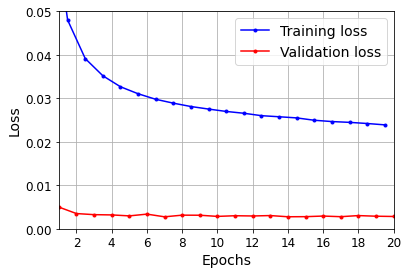

In [ ]:
plot_learning_curves(history_LSTM.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model_LSTM.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

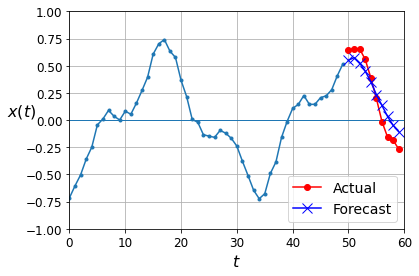

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_GRU = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_GRU.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_GRU = model_GRU.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 46s 7ms/sample - loss: 0.0745 - last_time_step_mse: 0.0668 - val_loss: 0.0526 - val_last_time_step_mse: 0.0413
Epoch 2/20
7000/7000 [==============================] - 37s 5ms/sample - loss: 0.0478 - last_time_step_mse: 0.0369 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 41s 6ms/sample - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0395 - val_last_time_step_mse: 0.0275
Epoch 4/20
7000/7000 [==============================] - 40s 6ms/sample - loss: 0.0375 - last_time_step_mse: 0.0250 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 66s 9ms/sample - loss: 0.0327 - last_time_step_mse: 0.0178 - val_loss: 0.0311 - val_last_time_step_mse: 0.0156
Epoch 6/20
7000/7000 [==============================] - 87s 12ms/sample - loss: 0.0309 - last_time_step_mse: 0.0157 -

In [ ]:
model_GRU.evaluate(X_valid, Y_valid, verbose=2)

2000/1 - 2s - loss: 0.0234 - last_time_step_mse: 0.0104


[0.024027102187275887, 0.0103580495]

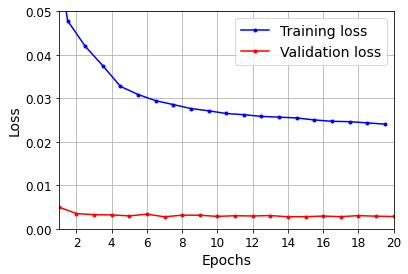

In [ ]:
plot_learning_curves(history_GRU.history["loss"], history.history["val_loss"])
plt.show()

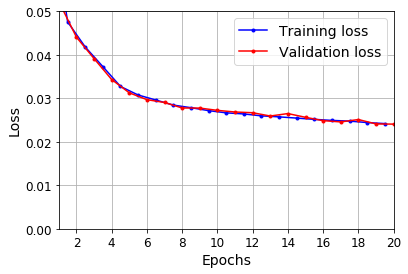

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

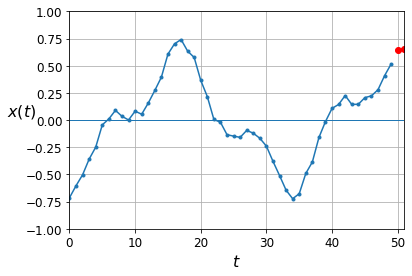

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

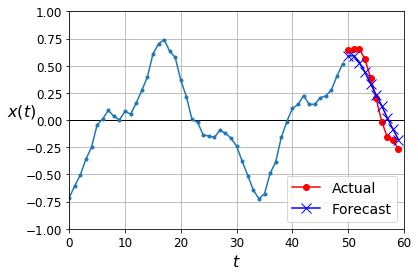

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 25s 4ms/sample - loss: 0.0686 - last_time_step_mse: 0.0609 - val_loss: 0.0485 - val_last_time_step_mse: 0.0406
Epoch 2/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0420 - last_time_step_mse: 0.0346 - val_loss: 0.0370 - val_last_time_step_mse: 0.0290
Epoch 3/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0341 - last_time_step_mse: 0.0262 - val_loss: 0.0307 - val_last_time_step_mse: 0.0215
Epoch 4/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0282 - last_time_step_mse: 0.0183 - val_loss: 0.0258 - val_last_time_step_mse: 0.0149
Epoch 5/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0239 - val_last_time_step_mse: 0.0130
Epoch 6/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0236 - last_time_step_mse: 0.0128 - 

In [ ]:
model.evaluate(X_valid, Y_valid)

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_WN = keras.models.Sequential()
model_WN.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model_WN.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model_WN.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model_WN.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_WN = model_WN.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0668 - last_time_step_mse: 0.0541 - val_loss: 0.0361 - val_last_time_step_mse: 0.0225
Epoch 2/20
7000/7000 [==============================] - 6s 900us/sample - loss: 0.0320 - last_time_step_mse: 0.0196 - val_loss: 0.0309 - val_last_time_step_mse: 0.0195
Epoch 3/20
7000/7000 [==============================] - 6s 898us/sample - loss: 0.0278 - last_time_step_mse: 0.0159 - val_loss: 0.0268 - val_last_time_step_mse: 0.0147
Epoch 4/20
7000/7000 [==============================] - 6s 888us/sample - loss: 0.0258 - last_time_step_mse: 0.0140 - val_loss: 0.0249 - val_last_time_step_mse: 0.0127
Epoch 5/20
7000/7000 [==============================] - 6s 891us/sample - loss: 0.0248 - last_time_step_mse: 0.0131 - val_loss: 0.0242 - val_last_time_step_mse: 0.0123
Epoch 6/20
7000/7000 [==============================] - 6s 893us/sample - loss: 0.0239 - last_time_step_mse: 0.01

In [ ]:
model_WN.evaluate(X_valid, Y_valid, verbose=2)

2000/1 - 1s - loss: 0.0192 - last_time_step_mse: 0.0074


[0.019077946916222572, 0.0073503316]

####  Here is the original WaveNet defined in the paper: 

It uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 3s 443us/sample - loss: 0.1299 - last_time_step_mse: 0.1258 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
7000/7000 [==============================] - 2s 271us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190


Fundamentals of RNNs were used them to process sequences (namely, **time series**). 

In the process we also looked at other ways to process sequences, including CNNs. In the next chapters we will use RNNs for Natural Language Processing (NLP) and  will also look at the Transformer, an Attention-only architecture.

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [ ]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 337s 0us/step


In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [ ]:
train_files

['/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [ ]:
eval_files

['/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/Users/iordan/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']